# Notebook to analyze the data from AGNs catalogs

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.io import fits
# from astropy.table import Table
# from astropy.table import Column
# from astropy.table import MaskedColumn
# from astropy.table import hstack
# from astropy.table import vstack
# from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import getpass
import progressbar
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [6]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

---

## Reading data

In [7]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

It is important to keep in mind that columns with keys starting with `Flux Density...` are in `Jy`.  
All the other values, are expressed in `mJy`.

Columns with uncertainties (`NED Uncertainty...`) have been saved as strings, to preserve possible upper limits.

In [8]:
# large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned_all_cols.h5', 'df')

Data could be also converted into `astropy` Tables.

In [9]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [10]:
# np.savetxt(cat_path + 'column_names_flx.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')
# np.savetxt(cat_path + 'column_names_flx_2_5_arcsec.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

From the querying process, some columns have the same identifier.  
In those cases, the suffix `_x` or `_y` has been added (`_x` for `simbad` data, and `_y` for `Ned` photometry).
One example is shown below.

In [11]:
# large_catalog_df.loc[90:100, ['MAIN_ID_x', 'MAIN_ID_y']]

---

## Organize data

Separate data into different arrays for calculations

Repeated keywords are: `MAIN_ID_x`, `MAIN_ID_y`, `COORD_x`, and `COORD_y`

The following redshift column comes from `SDSS` with the highest quality flag selected.

In [12]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
L_20cm      = large_catalog_df['L_20CM']
L_20cm_e    = large_catalog_df['L_20CM_ERR']
L_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']

We can calculate luminosities from fluxes.

In this case, we first select the columns with fluxes in a numerical format  
(with this all error columns are discarded for the moment).

In [13]:
numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
                                                                           'FLUX_ERROR_K', 'Z_OWN'])
#numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'D_LUM', 'FLUX_ERROR_B',\
#                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                           'FLUX_ERROR_K', 'JOINED_F_14GHZ', 'TEST_14_LUM',\
#                                                                           'Z_OWN'])

We create a new `pandas` `DataFrame` object to contain our luminosities,  
and we calculate them taking into account the difference in units for some of the  
columns with fluxes.

In [14]:
lums_catalog_df                       = pd.DataFrame()

In [15]:
for col_name in numeric_col_names:
    if 'F_' in col_name:
        lum_col_name                  = col_name.replace('F_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'FLUX_' in col_name:
        lum_col_name                  = col_name.replace('FLUX_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'Flux Density' in col_name:
        lum_col_name                  = col_name.replace('Flux Density', 'Luminosity')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name] * 1e3, redshift) 

For future use and reference, we can add new columns to the original catalog. 

In [16]:
lf_catalog_cols = lums_catalog_df.columns

One such column contains luminosity distances calculated from redshift values.

In [17]:
# large_catalog_df['D_LUM']           = cosmo.luminosity_distance(large_catalog_df['Z_OWN']).to(u.m).value

Our catalog contains several columns with observations in very similar  
frequencies and configurations.  
As a way to gather them, we can create a new column with the **average**  
(in `mJy`) of all the $1.4$ GHz fluxes. 

In [18]:
# large_catalog_df['F_1.4GHZ_average'] = (large_catalog_df[['Flux Density 1.4GHz', 'Flux Density 1.40 GHz',\
#                                 'Flux Density 1.4 GHz', 'Flux Density 1420.5 MHz',\
#                                 'Flux Density 1.42 GHz', 'Flux Density 1425 MHz',\
#                                 'Flux Density 1410 MHz', 'Flux Density 1.4 GHz VLA B-array']].mean(axis=1) * 1e3 + large_catalog_df['F_20CM']) / 2

From this new column, luminosities can be obtained and added to the recently created table.

In [19]:
# joined_lum_14GHz = lum_from_flux(large_catalog_df['JOINED_F_14GHZ'], redshift)
# lums_catalog_df['LUMINOSITY_1.4GHZ_average'] = lum_from_flux(large_catalog_df['F_1.4GHZ_average'], redshift)

As before, we can create a file to save the names of this new table with luminosities

In [20]:
# np.savetxt(cat_path + 'column_names_lum.txt', lums_catalog_df.columns, fmt='%s', delimiter='\n')

Only for calculation purposes, we can show the luminosity columns with the ($10$) highest number of elements.

In [21]:
stats_lums  = pd.DataFrame(lums_catalog_df.describe().loc['count'])
counts_lums = stats_lums.sort_values('count', ascending=False)
counts_lums[:10]

,count
LUMINOSITY_20CM,17957.0
LUMINOSITY_V,9166.0
LUMINOSITY_B,9062.0
Luminosity 4.5 microns (IRAC),8423.0
Luminosity 3.6 microns (IRAC),8402.0
Luminosity 5.8 microns (IRAC),8257.0
Luminosity 8.0 microns (IRAC),8117.0
LUMINOSITY_K,8102.0
Luminosity W1 (WISE),7943.0
Luminosity g (SDSS PSF) AB,7566.0


We can also attempt to merge the values from some columns. This can be done with features  
observed in similar (or equal) frequencies.

In order to do this, we can first import a list of all the used Passbands used in our table  
with their frequencies (Only measurements from `Ned`).

In [22]:
# band_names = np.loadtxt(cat_path + 'all_ned_band_names.txt', usecols=[0], dtype=np.str, delimiter='\t')
# band_freqs = np.loadtxt(cat_path + 'all_ned_band_names.txt', usecols=[1], dtype=np.float, delimiter='\t')
# band_names = np.loadtxt(cat_path + 'all_ned_band_names_2_5arcsec.txt', usecols=[0], dtype=np.str, delimiter='\t')
# band_freqs = np.loadtxt(cat_path + 'all_ned_band_names_2_5arcsec.txt', usecols=[1], dtype=np.float, delimiter='\t')

If the file `all_ned_band_names_2_5arcsec.txt` is used, a different approach  
should be used.

In [23]:
with open('all_ned_band_names_2_5arcsec.txt') as fp:  # Data already sorted by frequency
    lines_bands = fp.readlines()

In [24]:
band_names = []
band_freqs = []

In [25]:
for line in lines_bands:
    line    = line.strip()
    line_sp = line.split(' ')
    name    = ' '.join(line_sp[:-1])
    freq    = np.float(line_sp[-1])
    if name in band_names: continue
    band_names.append(name)
    band_freqs.append(freq)
band_names_temp  = np.array(band_names)
band_freqs_temp  = np.array(band_freqs)  # Frequencies sorted alphabetically (as strings)
band_names       = band_names_temp[np.argsort(band_freqs_temp)]
band_freqs       = band_freqs_temp[np.argsort(band_freqs_temp)]

These bands can be ordered by observed frequency.

In [26]:
np.shape(band_freqs)

(815,)

In [27]:
band_names_ord    = band_names
band_freqs_ord    = band_freqs
band_freqs_ord_2d = np.c_[band_freqs_ord, np.zeros_like(band_freqs_ord)]  # Make it a 2-D array for future calculations

In [28]:
band_names_lum     = np.array(['Luminosity ' + band_name for band_name in band_names])
band_names_ord_lum = np.array(['Luminosity ' + band_name for band_name in band_names_ord])

In [29]:
lums_band_names_freqs_pd = pd.Series(band_names_ord_lum, index=band_freqs_ord)

Repeat procedure used to obtain data table: join features with almost identical passband names.

In [30]:
np.shape(np.unique(band_names_lum))

(815,)

Now, there are no repeated exact names in the bands list.

In [31]:
np.shape(lums_catalog_df)

(18023, 823)

Calculate pair-wise distance among all frequencies (output is a matrix)

In [32]:
band_freqs_dists  = pd.DataFrame(data=distance.squareform(distance.pdist(band_freqs_ord_2d, metric='euclidean')),\
                                index=band_names_lum, columns=band_names_lum)

Group features with similar names and frequencies very close to each other.

In [33]:
band_names_groups_orig  = []
band_names_groups_repl  = []
used_band_names         = []
for index, (band_name, band_freq) in enumerate(zip(band_names_lum, band_freqs)):
    # str_to_search = ' '.join(re.findall(r'[A-Za-z]+|\d*[.,-]?\d+', re.sub(r' \(.*', '', str(band_name)).strip()))
    if band_name not in list(itertools.chain.from_iterable(band_names_groups_orig)):
        used_band_names.append(band_name)
        filter_dist = (band_freqs_dists[band_name] < 2.5)  # 2.5 % difference between band frequencies
        if np.ndim(filter_dist) > 1:
            filter_dist = filter_dist.iloc[:, 0]
        band_names_groups_orig.append(band_names_lum[filter_dist].tolist())
#        band_names_groups_repl.append(['Luminosity ' + re.sub(r' \(.*', '', name).strip()\
#                                       for name in band_names_ord[filter_dist].tolist()\
#                                      if 'Luminosity ' + re.sub(r' \(.*', '', name).strip() in lf_catalog_cols])

Create new table with luminosities. Features from the previously defined groups will be averaged and saved as  
one single column.

In [34]:
pre_merged_lums_catalog_df = pd.DataFrame()
for element in band_names_groups_orig:
    if len(element) == 0: continue
    if len(element) == 1: 
        pre_merged_lums_catalog_df[element] = lums_catalog_df[element]
        continue
    # lums_catalog_df[np.unique(band_names_groups_repl[0], axis=0)].describe()
    test_table = lums_catalog_df[np.unique(element, axis=0)].median(axis='columns', skipna=True)
    # test_table = test_table.rename(np.unique(element, axis=0)[0])
    pre_merged_lums_catalog_df[np.unique(element, axis=0)[0]] = test_table

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Now, the same procedure. But to merge features with similar names (a match before the parenthesis).

In [35]:
pre_merged_column_names = pre_merged_lums_catalog_df.columns

In [36]:
band_names_groups_trim_dict = {}
# band_names_groups_repl  = []
used_band_names_trim        = []
for index, band_name in enumerate(pre_merged_column_names):
    str_to_search = ' '.join(re.findall(r'[A-Za-z]+|\d*[.,-]?\d+', re.sub(r' \(.*', '', str(band_name)).strip()))
    if str_to_search not in used_band_names_trim:
        band_names_groups_trim_dict[str_to_search] = [band_name]
    if str_to_search in used_band_names_trim:
        band_names_groups_trim_dict[str_to_search].append(band_name)
    used_band_names_trim.append(str_to_search)

In [37]:
band_names_groups_trim = []
for key in band_names_groups_trim_dict:
    band_names_groups_trim.append(band_names_groups_trim_dict[key])

In [38]:
merged_lums_catalog_df = pd.DataFrame()

for key in band_names_groups_trim_dict:
    merged_lums_catalog_df[key] = pre_merged_lums_catalog_df[band_names_groups_trim_dict[key]].median(axis='columns', skipna=True)

Merge more columns by hand.

In [39]:
new_name  = 'Luminosity 10 GHz'
old_names = ['Luminosity 10.45 GHz', 'Luminosity 10.7 GHz', 'Luminosity 10.6 GHz Effelsberg']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [40]:
new_name  = 'Luminosity NUV'
old_names = ['Luminosity NUV', 'Luminosity UVM 2', 'Luminosity NUV max', 'Luminosity UVW 2', 'Luminosity C III 1909']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [41]:
new_name  = 'Luminosity 1.4-1.7 GHz'
old_names = ['Luminosity 1.4 GHz', 'Luminosity 1.38 GHz', 'Luminosity 1.408 GHz', 'Luminosity 1.418 GHz',\
             'Luminosity 1484 MHz', 'Luminosity 1.49 GHz', 'Luminosity 20 cm', 'Luminosity 1.6 GHz',\
            'Luminosity 1.65 GHz', 'Luminosity 1658 MHz', 'Luminosity 1.7 GHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [42]:
new_name  = 'Luminosity 250 GHz'
old_names = ['Luminosity 1300 microns', 'Luminosity 1.3 mm', 'Luminosity 1.25 mm', 'Luminosity 1.2 mm',\
            'Luminosity 203.850 GHz', 'Luminosity 215 GHz', 'Luminosity 226 GHz', 'Luminosity 229 GHz',\
             'Luminosity 244.603 GHz', 'Luminosity 270 GHz', 'Luminosity 1.1 mm']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [43]:
new_name  = 'Luminosity 15 GHz'
old_names = ['Luminosity 15 GHz', 'Luminosity 14.9 GHz', 'Luminosity 15.2 GHz', 'Luminosity 14 GHz',\
             'Luminosity 15064 MHz', 'Luminosity 15.7 GHz', 'Luminosity 16.1 GHz',]
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [44]:
new_name  = 'Luminosity H'
old_names = ['Luminosity H', 'Luminosity F 160 W']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [45]:
new_name  = 'Luminosity 4-60 microns'
old_names = ['Luminosity 15 microns', 'Luminosity Ne III 15.5', 'Luminosity Cl II 14.37', 'Luminosity Ne V',\
            'Luminosity 60 microns', 'Luminosity 30 microns', 'Luminosity H 2 S 0 line', 'Luminosity Fe II 15.99',\
             'Luminosity O IV', 'Luminosity 25 microns', 'Luminosity Ne V 24.32', 'Luminosity 24 microns',\
             'Luminosity 22 microns', 'Luminosity Q', 'Luminosity 20 microns', 'Luminosity S III 18.7',\
             'Luminosity L 18 W', 'Luminosity 18 microns', 'Luminosity H 2 S 1 line', 'Luminosity 16 microns',\
             'Luminosity NeIII 15.6 microns', 'Luminosity 12 microns', 'Luminosity 12.8 microns', 'Luminosity 11.3 microns',\
            'Luminosity H 2 S 2 line', 'Luminosity 12.0 microns', 'Luminosity W 3', 'Luminosity PAH 11.2',\
             'Luminosity 11 microns', 'Luminosity S IV 10.51', 'Luminosity S IV 10.5', 'Luminosity S 11',\
             'Luminosity N', 'Luminosity 10 microns', 'Luminosity 8 microns', 'Luminosity 7.7 microns',\
             'Luminosity log nu Hz 13.48', 'Luminosity H 2 S 3 line', 'Luminosity Ar III 8.99', 'Luminosity 7.9 microns Spitzer',\
             'Luminosity 8.0 microns', 'Luminosity 7.3 microns', 'Luminosity 5 microns', 'Luminosity 6 microns',\
             'Luminosity 4.5 microns', 'Luminosity 5.8 microns', 'Luminosity 6.7 microns', 'Luminosity PAH 6.2',\
             'Luminosity H 2 S 7 line', 'Luminosity 5.5 microns Spitzer', 'Luminosity 4.8 microns', 'Luminosity W 2',\
             'Luminosity 4.6 microns', 'Luminosity N 4']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [46]:
new_name  = 'Luminosity FUV'
old_names = ['Luminosity FUV', 'Luminosity 1549 A', 'Luminosity C IV line', 'Luminosity Si III 1892', 'Luminosity 1700 A',\
             'Luminosity He II 1640', 'Luminosity FUV max']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [47]:
new_name  = 'Luminosity Ly alpha'
old_names = ['Luminosity Ly alpha', 'Luminosity N V 1240', 'Luminosity Si IV O IV', 'Luminosity 1350 A', 'Luminosity O I 1304',\
             'Luminosity 1280 A']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [48]:
new_name  = 'Luminosity Y'
old_names = ['Luminosity Y', 'Luminosity O I 8446', 'Luminosity log nu Hz 14.45']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [49]:
new_name  = 'Luminosity z'
old_names = ['Luminosity z', 'Luminosity F 850 LP', 'Luminosity Z', 'Luminosity O I 11287']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [50]:
new_name  = 'Luminosity I'
old_names = ['Luminosity I', 'Luminosity i', 'Luminosity F 775 W', 'Luminosity log nu Hz 14.50',\
             'Luminosity Z aper', 'Luminosity F 814 W', 'Luminosity log nu Hz 14.60']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [51]:
new_name  = 'Luminosity r'
old_names = ['Luminosity r', 'Luminosity R', 'Luminosity log nu Hz 14.65', 'Luminosity N II',\
             'Luminosity H alpha', 'Luminosity 103 a E', 'Luminosity O I 6300',\
             'Luminosity CCD grism r 4', 'Luminosity log nu Hz 14.70', 'Luminosity Na I He I']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [52]:
new_name  = 'Luminosity V'
old_names = ['Luminosity V', 'Luminosity F 606 W', 'Luminosity O III 4959', 'Luminosity F 555 W']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [53]:
new_name  = 'Luminosity B'
old_names = ['Luminosity B', 'Luminosity b J', 'Luminosity H gamma', 'Luminosity B W', 'Luminosity 103 a O',\
             'Luminosity Ne III 3869', 'Luminosity Fe II 4570', 'Luminosity O III 4363']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [54]:
new_name  = 'Luminosity u'
old_names = ['Luminosity u', 'Luminosity U', 'Luminosity O II 3727', 'Luminosity log nu Hz 14.85',\
             'Luminosity H delta 4101', 'Luminosity N 396 12', 'Luminosity log nu Hz 14.90', 'Luminosity U aper']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [55]:
new_name  = 'Luminosity 2.2-8 GHz'
old_names = ['Luminosity 8 GHz', 'Luminosity 8.4 GHz', 'Luminosity 8.46 GHz', 'Luminosity 8.6 GHz',\
             'Luminosity 8085 MHz', 'Luminosity 8.35 GHz Effelsberg', 'Luminosity 8.44 GHz', 'Luminosity 8.48 GHz',\
             'Luminosity 8.5 GHz', 'Luminosity 3.1 GHz', 'Luminosity 3.9 GHz', 'Luminosity 7.6 cm', 'Luminosity 5 GHz',\
             'Luminosity 4.8 GHz', 'Luminosity 4.85 GHz', 'Luminosity 4.86 GHz', 'Luminosity 4.9 GHz',\
             'Luminosity 4585 MHz', 'Luminosity 4775 MHz', 'Luminosity 4830 MHz', 'Luminosity 4885 MHz',\
             'Luminosity 4.89 GHz', 'Luminosity 2.2 GHz', 'Luminosity 2 GHz', 'Luminosity 2263 MHz', 'Luminosity 2.3 GHz',\
             'Luminosity 2.64 GHz Effelsberg', 'Luminosity 2.70 GHz Effelsberg']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [56]:
new_name  = 'Luminosity K'
old_names = ['Luminosity K', 'Luminosity 3.6 microns', 'Luminosity 3.4 microns', 'Luminosity L', 'Luminosity 3.7 microns',\
             'Luminosity log nu Hz 13.934', 'Luminosity W 1']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [57]:
new_name  = 'Luminosity 10-38 MHz'
old_names = ['Luminosity 10 MHz', 'Luminosity 22.25 MHz', 'Luminosity 22 MHz', 'Luminosity 26.3 MHz', 'Luminosity 38 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [58]:
new_name  = 'Luminosity 60-86 MHz'
old_names = ['Luminosity 60 MHz', 'Luminosity 74 MHz', 'Luminosity 80 MHz', 'Luminosity 86 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [59]:
new_name  = 'Luminosity 150-178 MHz'
old_names = ['Luminosity 150 MHz', 'Luminosity 151 MHz', 'Luminosity 153 MHz', 'Luminosity 160 MHz', 'Luminosity 178 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [60]:
new_name  = 'Luminosity 230 MHz'
old_names = ['Luminosity 230 MHz', 'Luminosity 235 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [61]:
new_name  = 'Luminosity 318-365 MHz'
old_names = ['Luminosity 318 MHz', 'Luminosity 320.2 MHz', 'Luminosity 324 MHz', 'Luminosity 324.5 MHz', 'Luminosity 327 MHz',\
             'Luminosity 336.4 MHz', 'Luminosity 340 MHz', 'Luminosity 365 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [62]:
new_name  = 'Luminosity 408-430 MHz'
old_names = ['Luminosity 0.408 GHz', 'Luminosity 408 MHz', 'Luminosity 430 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [63]:
new_name  = 'Luminosity 599-635 MHz'
old_names = ['Luminosity 599.28 MHz', 'Luminosity 609 MHz', 'Luminosity 610 MHz', 'Luminosity 635 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [64]:
new_name  = 'Luminosity 700-785 MHz'
old_names = ['Luminosity 700.02 MHz', 'Luminosity 750 MHz', 'Luminosity 767.04 MHz', 'Luminosity 785.80 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [65]:
new_name  = 'Luminosity 967 MHz'
old_names = ['Luminosity 966 MHz', 'Luminosity 968 MHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [66]:
new_name  = 'Luminosity 22-163 GHz'
old_names = ['Luminosity 22 GHz', 'Luminosity 22.46 GHz', 'Luminosity 23 GHz', 'Luminosity 22 GHz', 'Luminosity 24 GHz',\
             'Luminosity 28.5 GHz', 'Luminosity 30 GHz', 'Luminosity 31400 MHz', 'Luminosity 32 GHz', 'Luminosity 33 GHz',\
             'Luminosity 34 GHz', 'Luminosity 37 GHz', 'Luminosity 31 GHz', 'Luminosity 41 GHz', 'Luminosity 43 GHz',\
             'Luminosity 43.34 GHz', 'Luminosity 43.2 GHz', 'Luminosity 43.4 GHz', 'Luminosity 44 GHz', 'Luminosity 61 GHz',\
             'Luminosity 70 GHz', 'Luminosity 77 GHz', 'Luminosity 81.551 GHz', 'Luminosity 86.9 GHz', 'Luminosity 87.3 GHz',\
             'Luminosity 89600 MHz', 'Luminosity 90 GHz', 'Luminosity 86 GHz', 'Luminosity 94 GHz', 'Luminosity 3 mm',\
             'Luminosity 100 GHz', 'Luminosity 105.4 GHz', 'Luminosity 136.2 GHz', 'Luminosity 143 GHz',\
             'Luminosity 150 GHz','Luminosity 163.088 GHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [67]:
new_name  = 'Luminosity 300-375 GHz'
old_names = ['Luminosity 300 GHz', 'Luminosity CO 3-2', 'Luminosity 890 microns', 'Luminosity 345 GHz',\
             'Luminosity 350 GHz', 'Luminosity 850 microns', 'Luminosity 375 GHz']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [68]:
new_name  = 'Luminosity 450-500 microns'
old_names = ['Luminosity 500 microns', 'Luminosity 450 microns', 'Luminosity CO 6-5']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [69]:
new_name  = 'Luminosity 150-350 microns'
old_names = ['Luminosity 350 microns', 'Luminosity 250 microns', 'Luminosity 200 microns',\
             'Luminosity 170 microns', 'Luminosity 160 microns', 'Luminosity 150 microns', 'Luminosity C II 158']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [70]:
new_name  = 'Luminosity 70-100 microns'
old_names = ['Luminosity 100 microns', 'Luminosity 90 microns', 'Luminosity 70 microns', 'Luminosity O I']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [71]:
new_name  = 'Luminosity g'
old_names = ['Luminosity g', 'Luminosity log nu Hz 14.75', 'Luminosity 5100 A', 'Luminosity O III']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [72]:
new_name  = 'Luminosity G'
old_names = ['Luminosity G', 'Luminosity 4861 A', 'Luminosity log nu Hz 14.80']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [73]:
new_name  = 'Luminosity 3000 A'
old_names = ['Luminosity 3000 A', 'Luminosity Ne V 3425', 'Luminosity log nu Hz 14.95']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [74]:
new_name  = 'Luminosity 2500 A'
old_names = ['Luminosity 2500 A', 'Luminosity Fe II line', 'Luminosity UVW 1', 'Luminosity Mg II']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [75]:
new_name  = 'Luminosity 830-1030 A'
old_names = ['Luminosity 1030 A', 'Luminosity 1000 A', 'Luminosity 830 A']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [76]:
new_name  = 'Luminosity 0.1-12 keV'
old_names = ['Luminosity 0.5 -1 keV', 'Luminosity 1 keV', 'Luminosity 0.2 -2 keV', 'Luminosity 0.3 -2 keV',\
             'Luminosity 0.1 -2 .4 keV', 'Luminosity 0.7 -2 keV', 'Luminosity 0.3 -2 .5 keV Chandra',\
             'Luminosity 0.5 -2 .5 keV Chandra', 'Luminosity 0.3 -3 .5 keV', 'Luminosity 0.15 -3 .5 keV',\
             'Luminosity 0.3 -3 .5 keV Einstein', 'Luminosity 2 keV', 'Luminosity 0.5 -4 .5 keV', 'Luminosity 2.0 -4 keV',\
             'Luminosity 0.5 -7 keV', 'Luminosity 0.7 -7 keV', 'Luminosity 4 keV', 'Luminosity 0.3 -8 keV',\
             'Luminosity 0.35 -8 keV', 'Luminosity 0.5 -8 keV', 'Luminosity 2-7 keV', 'Luminosity 0.5 -10 keV',\
             'Luminosity 0.2 -10 keV', 'Luminosity 0.3 -10 keV', 'Luminosity 2-10 keV', 'Luminosity 0.2 -12 keV',\
             'Luminosity 6.4 keV Fe K alpha', 'Luminosity 5-10 keV']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names, inplace=True, axis='columns')

In [77]:
new_name  = 'Luminosity 14-195 keV'
old_names = ['Luminosity 14-195 keV', 'Luminosity 15-150 keV', 'Luminosity 15-55 keV']
merged_lums_catalog_df[new_name] = merged_lums_catalog_df[old_names].median(axis='columns', skipna=True)
merged_lums_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [78]:
merged_lums_catalog_df.columns.to_numpy()

array(['Luminosity 111 MHZ', 'Luminosity 230 MHz', 'Luminosity 15 GHz',
       'Luminosity 20 GHz', 'Luminosity HI 7-6', 'Luminosity 3 microns',
       'Luminosity K', 'Luminosity HK', 'Luminosity H', 'Luminosity J',
       'Luminosity z', 'Luminosity Y', 'Luminosity I',
       'Luminosity S II 6716', 'Luminosity r', 'Luminosity V',
       'Luminosity g', 'Luminosity G', 'Luminosity B', 'Luminosity u',
       'Luminosity 2500 A', 'Luminosity NUV', 'Luminosity FUV',
       'Luminosity Ly alpha', 'Luminosity 14-195 keV', 'Luminosity EGRET',
       'Luminosity 0.1 -100 GeV', 'Luminosity 10 GHz',
       'Luminosity 1.4-1.7 GHz', 'Luminosity 250 GHz',
       'Luminosity 4-60 microns', 'Luminosity 2.2-8 GHz',
       'Luminosity 10-38 MHz', 'Luminosity 60-86 MHz',
       'Luminosity 150-178 MHz', 'Luminosity 318-365 MHz',
       'Luminosity 408-430 MHz', 'Luminosity 599-635 MHz',
       'Luminosity 700-785 MHz', 'Luminosity 967 MHz',
       'Luminosity 22-163 GHz', 'Luminosity 300-375 GHz',
 

In [79]:
# 'Luminosity 10 MHz', 'Luminosity 22.25 MHz', 'Luminosity 22 MHz', 'Luminosity 26.3 MHz', 'Luminosity 38 MHz', 
# 'Luminosity 60 MHz', 'Luminosity 74 MHz', 'Luminosity 80 MHz', 'Luminosity 86 MHz',
# 'Luminosity 111 MHZ', 
# 'Luminosity 150 MHz', 'Luminosity 151 MHz', 'Luminosity 153 MHz', 'Luminosity 160 MHz', 'Luminosity 178 MHz',
# 'Luminosity 230 MHz', 'Luminosity 235 MHz', 
# 'Luminosity 318 MHz', 'Luminosity 320.2 MHz', 'Luminosity 324 MHz', 'Luminosity 324.5 MHz', 'Luminosity 327 MHz', 'Luminosity 336.4 MHz', 'Luminosity 340 MHz', 'Luminosity 365 MHz',
# 'Luminosity 0.408 GHz', 'Luminosity 408 MHz', 'Luminosity 430 MHz',
# 'Luminosity 599.28 MHz', 'Luminosity 609 MHz', 'Luminosity 610 MHz', 'Luminosity 635 MHz',
# 'Luminosity 700.02 MHz', 'Luminosity 750 MHz', 'Luminosity 767.04 MHz', 'Luminosity 785.80 MHz',
# 'Luminosity 966 MHz', 'Luminosity 968 MHz', 
# 'Luminosity 1.4 GHz', 'Luminosity 20 cm', 'Luminosity 1.6 GHz', 
# 'Luminosity 2.2 GHz', 'Luminosity 2 GHz', 'Luminosity 2263 MHz', 'Luminosity 2.3 GHz', 'Luminosity 2.64 GHz Effelsberg', 'Luminosity 2.70 GHz Effelsberg',
# 'Luminosity 3.1 GHz', 'Luminosity 3.9 GHz', 'Luminosity 7.6 cm', 'Luminosity 8 GHz',
# 'Luminosity 4585 MHz', 'Luminosity 4775 MHz', 'Luminosity 4830 MHz', 'Luminosity 4885 MHz', 'Luminosity 4.89 GHz', 'Luminosity 5 GHz', 
# 'Luminosity 10.6 GHz Effelsberg', 
# 'Luminosity 14 GHz', 'Luminosity 15 GHz', 'Luminosity 15064 MHz', 'Luminosity 15.7 GHz', 'Luminosity 16.1 GHz', 
# 'Luminosity 20 GHz', 'Luminosity 22 GHz', 'Luminosity 24 GHz', 'Luminosity 28.5 GHz', 'Luminosity 30 GHz', 'Luminosity 31400 MHz', 'Luminosity 32 GHz', 'Luminosity 34 GHz',
# 'Luminosity 43.2 GHz', 'Luminosity 43.4 GHz', 'Luminosity 44 GHz', 'Luminosity 61 GHz', 'Luminosity 70 GHz', 'Luminosity 77 GHz', 'Luminosity 81.551 GHz', 'Luminosity 86.9 GHz', 'Luminosity 87.3 GHz', 'Luminosity 89600 MHz', 'Luminosity 90 GHz',
# 'Luminosity 100 GHz', 'Luminosity 105.4 GHz', 'Luminosity 136.2 GHz', 'Luminosity 143 GHz', 'Luminosity 150 GHz','Luminosity 163.088 GHz', 
# 'Luminosity 203.850 GHz', 'Luminosity 215 GHz', 'Luminosity 226 GHz', 'Luminosity 229 GHz', 'Luminosity 244.603 GHz', 'Luminosity 270 GHz', 'Luminosity 1.1 mm', 
# 'Luminosity 300 GHz', 'Luminosity CO 3-2', 'Luminosity 890 microns', 'Luminosity 345 GHz', 'Luminosity 350 GHz', 'Luminosity 850 microns', 'Luminosity 375 GHz', 
# 'Luminosity 500 microns', 'Luminosity 450 microns', 'Luminosity CO 6-5',
# 'Luminosity 350 microns', 'Luminosity 250 microns', 'Luminosity 200 microns', 'Luminosity 170 microns', 'Luminosity 160 microns', 'Luminosity 150 microns', 'Luminosity C II 158', 
# 'Luminosity 100 microns', 'Luminosity 90 microns', 'Luminosity 70 microns', 'Luminosity O I',
# 'Luminosity 60 microns', 'Luminosity 30 microns', 'Luminosity H 2 S 0 line', 'Luminosity Fe II 15.99', 'Luminosity O IV', 'Luminosity 25 microns', 'Luminosity Ne V 24.32', 'Luminosity 24 microns', 'Luminosity 22 microns', 'Luminosity Q', 'Luminosity 20 microns', 'Luminosity S III 18.7', 'Luminosity L 18 W', 'Luminosity 18 microns', 'Luminosity H 2 S 1 line', 'Luminosity 16 microns', 'Luminosity NeIII 15.6 microns', 'Luminosity 15 microns', 
# 'Luminosity HI 7-6',
# 'Luminosity H 2 S 2 line', 'Luminosity 12 microns', 'Luminosity 12.0 microns', 'Luminosity W 3', 'Luminosity PAH 11.2', 'Luminosity 11 microns', 'Luminosity S IV 10.51', 'Luminosity S IV 10.5', 'Luminosity S 11', 'Luminosity N', 'Luminosity 10 microns', 
# 'Luminosity log nu Hz 13.48', 'Luminosity H 2 S 3 line', 'Luminosity Ar III 8.99', 'Luminosity 8 microns', 'Luminosity 7.9 microns Spitzer', 'Luminosity 8.0 microns', 'Luminosity 7.3 microns',
# 'Luminosity 6.7 microns', 'Luminosity PAH 6.2', 'Luminosity H 2 S 7 line', 'Luminosity 5.5 microns Spitzer', 'Luminosity 5 microns', 'Luminosity 4.8 microns', 'Luminosity W 2', 'Luminosity 4.6 microns', 'Luminosity N 4', 
# 'Luminosity L', 'Luminosity 3.7 microns', 'Luminosity log nu Hz 13.934', 'Luminosity W 1', 'Luminosity 3 microns', 'Luminosity K',
# 'Luminosity HK', 
# 'Luminosity H',
# 'Luminosity J',
# 'Luminosity z', 'Luminosity O I 11287', 
# 'Luminosity log nu Hz 14.45', 'Luminosity Y', 
# 'Luminosity log nu Hz 14.50', 'Luminosity I', 'Luminosity Z aper', 'Luminosity F 814 W', 'Luminosity i', 'Luminosity log nu Hz 14.60', 
# 'Luminosity S II 6716',
# 'Luminosity CCD grism r 4', 'Luminosity r', 'Luminosity log nu Hz 14.70', 'Luminosity Na I He I',
# 'Luminosity V', 'Luminosity F 555 W', 
# 'Luminosity log nu Hz 14.75', 'Luminosity g', 'Luminosity 5100 A', 'Luminosity O III',
# 'Luminosity 4861 A', 'Luminosity G', 'Luminosity log nu Hz 14.80',
# 'Luminosity Fe II 4570', 'Luminosity B', 'Luminosity O III 4363', 
# 'Luminosity log nu Hz 14.85', 'Luminosity H delta 4101', 'Luminosity N 396 12', 'Luminosity u', 'Luminosity log nu Hz 14.90', 'Luminosity U aper',
# 'Luminosity Ne V 3425', 'Luminosity log nu Hz 14.95', 'Luminosity 3000 A', 
# 'Luminosity Fe II line', 'Luminosity UVW 1', 'Luminosity Mg II', 'Luminosity 2500 A', 
# 'Luminosity NUV', 'Luminosity NUV max', 'Luminosity UVW 2', 'Luminosity C III 1909',
# 'Luminosity Si III 1892', 'Luminosity 1700 A', 'Luminosity He II 1640', 'Luminosity FUV', 'Luminosity FUV max',
# 'Luminosity Si IV O IV', 'Luminosity 1350 A', 'Luminosity O I 1304', 'Luminosity 1280 A', 'Luminosity Ly alpha',
# 'Luminosity 1030 A', 'Luminosity 1000 A', 'Luminosity 830 A',
# 'Luminosity 0.5 -1 keV', 'Luminosity 1 keV', 'Luminosity 0.2 -2 keV', 'Luminosity 0.3 -2 keV', 'Luminosity 0.1 -2 .4 keV', 'Luminosity 0.7 -2 keV', 'Luminosity 0.3 -2 .5 keV Chandra', 'Luminosity 0.5 -2 .5 keV Chandra', 'Luminosity 0.3 -3 .5 keV', 'Luminosity 0.15 -3 .5 keV', 'Luminosity 0.3 -3 .5 keV Einstein', 'Luminosity 2 keV', 'Luminosity 0.5 -4 .5 keV', 'Luminosity 2.0 -4 keV', 
# 'Luminosity 0.5 -7 keV', 'Luminosity 0.7 -7 keV', 'Luminosity 4 keV', 'Luminosity 0.3 -8 keV', 'Luminosity 0.35 -8 keV', 'Luminosity 0.5 -8 keV', 'Luminosity 2-7 keV', 'Luminosity 0.5 -10 keV', 'Luminosity 0.2 -10 keV', 'Luminosity 0.3 -10 keV', 'Luminosity 2-10 keV', 'Luminosity 0.2 -12 keV', 'Luminosity 6.4 keV Fe K alpha', 'Luminosity 5-10 keV', 
# 'Luminosity 15-55 keV',
# 'Luminosity 15-150 keV', 'Luminosity 14-195 keV',
# 'Luminosity EGRET', 
# 'Luminosity 0.1 -100 GeV', 
# 'Luminosity 10 GHz',
# 'Luminosity 250 GHz', 
# 'Luminosity 40 GHz'

In [80]:
np.shape(merged_lums_catalog_df.columns.to_numpy())

(47,)

In [81]:
stats_lums_merged  = pd.DataFrame(merged_lums_catalog_df.describe().loc['count'])
counts_lums_merged = stats_lums_merged.sort_values('count', ascending=False)
counts_lums_merged[:10]

,count
Luminosity K,13021.0
Luminosity 4-60 microns,12922.0
Luminosity I,8442.0
Luminosity u,7834.0
Luminosity r,7596.0
Luminosity z,7593.0
Luminosity G,7573.0
Luminosity 1.4-1.7 GHz,5132.0
Luminosity NUV,1902.0
Luminosity FUV,1622.0


Incorporate luminosities from `SIMBAD` measurements and from initial **Inayoshi et al., 2020** catalog.

The columns `large_catalog_df['L_20CM']` and `lums_catalog_df['LUMINOSITY_20CM']` have the same  
number of elements and have the same values. But they have been calculated in different moments.

In [82]:
# hc.loc[hc["ID"].isnull(),'ID'] = hc["First Name"] + hc["Last Name"]

Keep $1.4$ GHz observations over `Ned` data.

In [83]:
# replace_20cm = np.nanmedian([merged_lums_catalog_df['Luminosity 1.4 GHz'].values, large_catalog_df['L_20CM'].values], axis=0)
# merged_lums_catalog_df['Luminosity 1.4 GHz'].replace(replace_20cm, inplace=True)

merged_lums_catalog_df.loc[~large_catalog_df['L_20CM'].isnull(), 'Luminosity 1.4-1.7 GHz'] = large_catalog_df['L_20CM']

In [84]:
# replace_B_band = np.nanmedian([merged_lums_catalog_df['Luminosity B'].values, lums_catalog_df['LUMINOSITY_B'].values], axis=0)
# merged_lums_catalog_df['Luminosity B'].replace(replace_B_band, inplace=True)

temp_data = pd.DataFrame({'Luminosity B':merged_lums_catalog_df['Luminosity B'], 'LUMINOSITY_B':lums_catalog_df['LUMINOSITY_B']})
merged_lums_catalog_df['Luminosity B'] = temp_data.median(axis='columns', skipna=True)

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [85]:
# replace_V_band = np.nanmedian([merged_lums_catalog_df['Luminosity V'].values, lums_catalog_df['LUMINOSITY_V'].values], axis=0)
# merged_lums_catalog_df['Luminosity V'].replace(replace_V_band, inplace=True)

temp_data = pd.DataFrame({'Luminosity V':merged_lums_catalog_df['Luminosity V'], 'LUMINOSITY_V':lums_catalog_df['LUMINOSITY_V']})
merged_lums_catalog_df['Luminosity V'] = temp_data.median(axis='columns', skipna=True)

In [86]:
# replace_R_band = np.nanmedian([merged_lums_catalog_df['Luminosity r'].values, lums_catalog_df['LUMINOSITY_R'].values], axis=0)
# merged_lums_catalog_df['Luminosity r'].replace(replace_R_band, inplace=True)

temp_data = pd.DataFrame({'Luminosity r':merged_lums_catalog_df['Luminosity r'], 'LUMINOSITY_R':lums_catalog_df['LUMINOSITY_R']})
merged_lums_catalog_df['Luminosity r'] = temp_data.median(axis='columns', skipna=True)

In [87]:
# replace_I_band = np.nanmedian([merged_lums_catalog_df['Luminosity I'].values, lums_catalog_df['LUMINOSITY_I'].values], axis=0)
# merged_lums_catalog_df['Luminosity I'].replace(replace_I_band, inplace=True)

temp_data = pd.DataFrame({'Luminosity I':merged_lums_catalog_df['Luminosity I'], 'LUMINOSITY_I':lums_catalog_df['LUMINOSITY_I']})
merged_lums_catalog_df['Luminosity I'] = temp_data.median(axis='columns', skipna=True)

In [88]:
# replace_J_band = np.nanmedian([merged_lums_catalog_df['Luminosity J'].values, lums_catalog_df['LUMINOSITY_J'].values], axis=0)
# merged_lums_catalog_df['Luminosity J'].replace(replace_J_band, inplace=True)

temp_data = pd.DataFrame({'Luminosity J':merged_lums_catalog_df['Luminosity J'], 'LUMINOSITY_J':lums_catalog_df['LUMINOSITY_J']})
merged_lums_catalog_df['Luminosity J'] = temp_data.median(axis='columns', skipna=True)

In [89]:
# replace_K_band = np.nanmedian([merged_lums_catalog_df['Luminosity K'].values, lums_catalog_df['LUMINOSITY_J'].values], axis=0)
# merged_lums_catalog_df['Luminosity K'].replace(replace_J_band, inplace=True)

temp_data = pd.DataFrame({'Luminosity K':merged_lums_catalog_df['Luminosity K'], 'LUMINOSITY_K':lums_catalog_df['LUMINOSITY_K']})
merged_lums_catalog_df['Luminosity K'] = temp_data.median(axis='columns', skipna=True)

In [90]:
# replace_250GHz = np.nanmedian([merged_lums_catalog_df['Luminosity 250 GHz'].values, lums_catalog_df['LUMINOSITY_250GHZ'].values], axis=0)
# merged_lums_catalog_df['Luminosity 250 GHz'].replace(replace_250GHz, inplace=True)

merged_lums_catalog_df.loc[~large_catalog_df['L_250GHZ'].isnull(), 'Luminosity 250 GHz'] = large_catalog_df['L_250GHZ']

---

In [91]:
np.shape(merged_lums_catalog_df.columns.to_numpy())

(47,)

---

## Plot initial values

We create an initial plot of $1.4$ GHz vs. redshift ($z$) for our sources.

Fix fluxes are added for ease of comprehension.

In [92]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [93]:
lum_FIRST      = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_50uJy      = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_20uJy      = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_10uJy      = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_5uJy       = 4 * np.pi * lum_dist_range**2 * 5e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_1uJy       = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [94]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [95]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

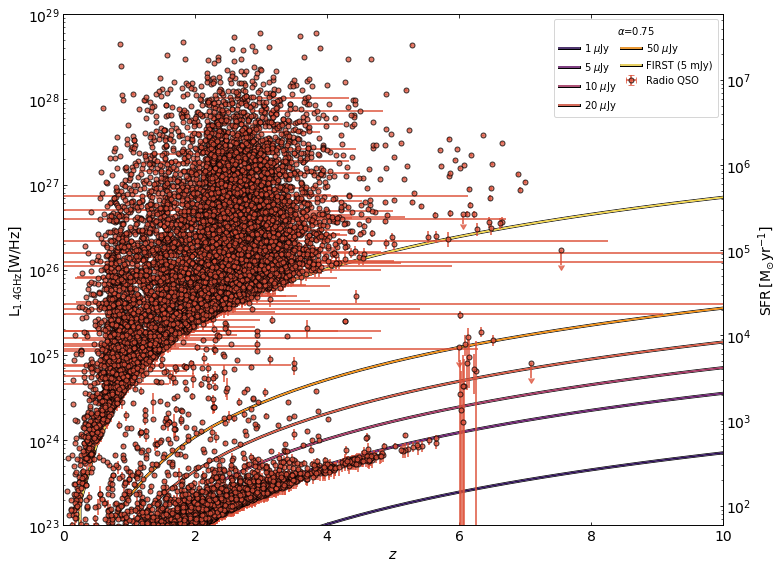

In [96]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, merged_lums_catalog_df['Luminosity 1.4-1.7 GHz'], xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')
# ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

#ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')

ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[2], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[4], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST (5 mJy)', color=colors[5], path_effects=pe1)
#ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
#ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
#gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
#gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


ax2 = ax1.twinx()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

We can see a very noticeable gap in our source distribution.
From the calculations in **Amarantidis et al., 2019**, we can explain this behavior  
from the selection biases of the different surveys involved in the production of our catalog. 

---

# Plot individual features

Another option to display the data is using histograms.  
From the selection of one column, we can create a plot.

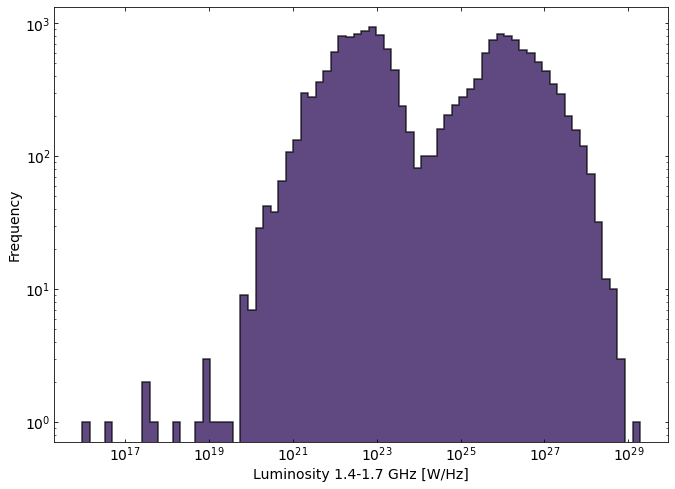

In [97]:
fig          = plt.figure(figsize=(11,8))
ax1          = fig.add_subplot(111)

col_name     = 'Luminosity 1.4-1.7 GHz'
col_name_str = col_name + ' [W/Hz]'

vmin_L       = np.log10(merged_lums_catalog_df[col_name].min())
vmax_L       = np.log10(merged_lums_catalog_df[col_name].max())
bins_L       = np.logspace(vmin_L, vmax_L, 75)

ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_xlabel(col_name_str, size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
merged_lums_catalog_df[col_name].plot.hist(color=colors[0], alpha=0.75, bins=bins_L, histtype='stepfilled', ec='k', lw=1.5)

For completeness, we can also create a histogram for the available redshift values.

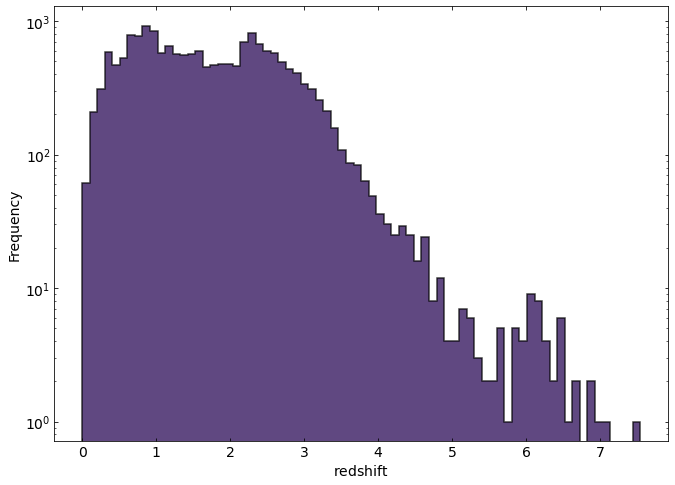

In [98]:
fig    = plt.figure(figsize=(11,8))
ax1    = fig.add_subplot(111)

vmin_z = redshift.min()
vmax_z = redshift.max()
bins_z = np.linspace(vmin_z, vmax_z, 75)

# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\mathrm{redshift}$', size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
redshift.plot.hist(color=colors[0], alpha=0.75, bins=bins_z, histtype='stepfilled', ec='k', lw=1.5)

We can also select two luminosity columns and plot them. We can color-code them by redshift  
and include histograms for both quantities.

In [99]:
lum_names           = merged_lums_catalog_df.columns

In [100]:
add_histograms_flag = True  # Add histograms to the folowing plot

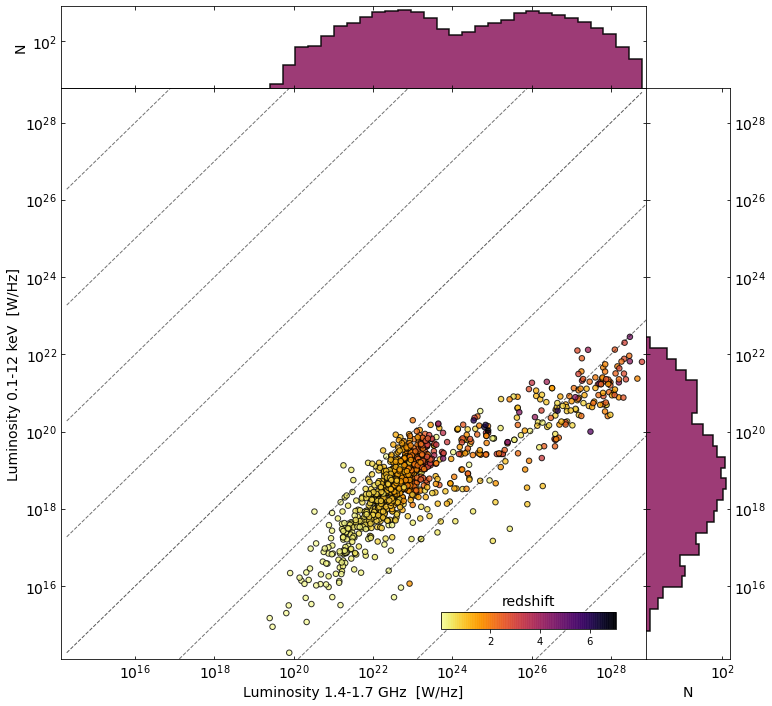

In [101]:
fig        = plt.figure(figsize=(12,12))

if not add_histograms_flag:
    ax1    = fig.add_subplot(111)

if add_histograms_flag:
    ax1    = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2    = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3    = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by number
# col_a = lum_names[0]
# col_b = lum_names[23]

# Select columns by name
col_a       = "Luminosity 1.4-1.7 GHz"
col_b       = "Luminosity 0.1-12 keV"

# Obtain luminosities and the cross-match between them
lum_a       = merged_lums_catalog_df[col_a]
lum_b       = merged_lums_catalog_df[col_b]
common_vals = np.multiply(lum_a, lum_b)

# Create log bins for log-scale histograms
min_val     = np.nanmin([lum_a[np.isfinite(common_vals)].min(), lum_b[np.isfinite(common_vals)].min()])
max_val     = np.nanmax([lum_a[np.isfinite(common_vals)].max(), lum_b[np.isfinite(common_vals)].max()])
bins_a      = np.logspace(np.log10(lum_a[np.isfinite(common_vals)].values.min()), np.log10(lum_a[np.isfinite(common_vals)].values.max()), 30)
bins_b      = np.logspace(np.log10(lum_b[np.isfinite(common_vals)].values.min()), np.log10(lum_b[np.isfinite(common_vals)].values.max()), 30)

ax1.set_yscale('log')
ax1.set_xscale('log')

# Format axis names and limits
if 'LUMINOSITY_' in col_a:
    col_a   = col_a.replace('LUMINOSITY_', 'Luminosity ') + ' (SIMBAD)'
if 'LUMINOSITY_' in col_b:
    col_b   = col_b.replace('LUMINOSITY_', 'Luminosity ') + ' (SIMBAD)'
ax1.set_xlabel(col_a + '  [W/Hz]', size=14)
ax1.set_ylabel(col_b + '  [W/Hz]', size=14)
ax1.set_ylim(min_val*0.7, max_val*1.3)
ax1.set_xlim(min_val*0.7, max_val*1.3)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)

sc          = ax1.scatter(lum_a, lum_b, c=redshift, cmap='inferno_r', s=30, alpha=0.80, edgecolor='black')

# Add 1-1 line and parallels for comparison
ax1.plot([min_val, max_val], [min_val, max_val], ls='dashed', color='k', alpha=0.65, lw=1)
for factor in [1e3, 1e6, 1e9, 1e12]:
    ax1.plot([min_val, max_val], [min_val*factor, max_val*factor], ls='dashed', color='k', alpha=0.55, lw=1)
    ax1.plot([min_val, max_val*factor], [min_val/factor, max_val], ls='dashed', color='k', alpha=0.55, lw=1)

# Create colorbar and plot it
cbaxes      = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
clb         = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# clb.set_label('redshift', size=14)
clb.ax.set_title('redshift', size=14)

ax1.set_aspect('auto', share=False, adjustable='box')

if add_histograms_flag:
    # Plot vertical histogram
    hist(lum_b.values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('N', size=14)
    
    # Plot horizontal histogram
    hist(lum_a.values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel('N', size=14)
    
    # Modify ticks
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
    ax3.tick_params(which='both',top=True, right=True, direction='in')
    
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

Another visualization option considers obtaining a kernel density estimation (`kde`) for the  
distribution of each column (luminosity). The tools of `pandas` allow us to do this.

(1e-50, 1.3233952373084597e-27)

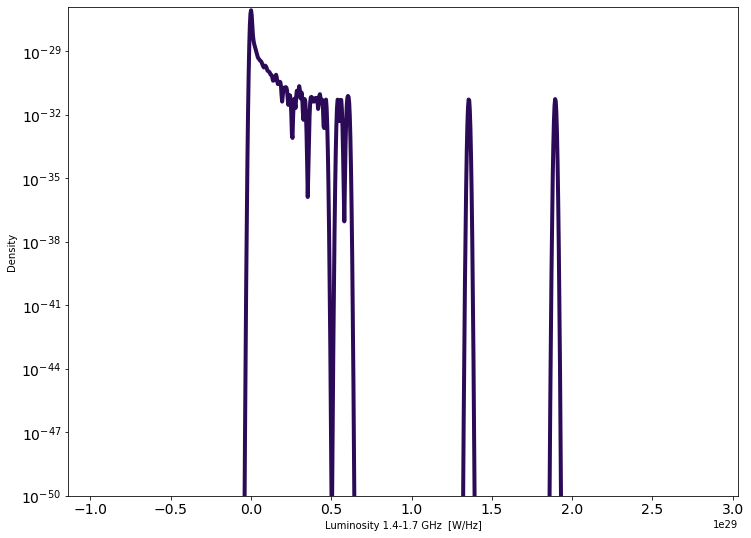

In [102]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

# Choose the column to use (from highly correlated luminosities)
# used_col_num = 2
# used_col     = cols_high_corr[used_col_num]

# Choose directly the column name
used_col     = "Luminosity 1.4-1.7 GHz"

merged_lums_catalog_df[used_col].plot.kde(ax=ax1, fontsize=14, logy=True, ylim=(1e-50, None), color=colors[0], lw=4)
ax1.set_xlabel(used_col + '  [W/Hz]');
ax1.set_ylim((1e-50, ax1.lines[0].get_data()[1].max() * 1.5))
# ax1.set_xlim((ax1.lines[0].get_data()[0].min(), ax1.lines[0].get_data()[0].max()))

This plot can be extended into a scatter matrix which shows individual distributions (`kde`) and pair-wise plots.  
In our case, and given the need of using logarithmic scales for the axes, the plots do not show completely well.  
We leave the code block but without being executed.

In [103]:
# # fig = plt.figure(figsize=(12,9))
# # ax1 = fig.add_subplot(111)

# axl = scatter_matrix(lums_catalog_df[cols_high_corr], alpha=0.2, diagonal='kde', figsize=(12,9))
# 
# for i, axs in enumerate(axl):
#     for j, ax in enumerate(axs):
#         ax.set_xscale('symlog')
#         ax.set_yscale('symlog')

---

# Obtain most highly correlated quantities

Make use of tools from `pandas` to calculate correlations between  
the luminosity columns and find the highest values.  
Pandas default behavior calculates the Pearson correlation coefficient (Kendall Tau and Spearman coefficients are also available).  
Since we do not know the exact behavior of our features, we choose Spearman's correlation coefficient.  
It is a non-parametric test that assesses monotonic relationships (something more general than linear  
relationships, as Pearson's does).

An interesting by-product of favoring Spearman over Pearson is that, since we are, mostly,  
visualizing our data in logarithmic scale, not only linear correlations can be spotted easily.  
Thus, what we can see (graphically) can match better the correlation values.

We can choose how many elements (sources) can be used for calculations. In our case,  
we want to use all of them.

It is also possible to avoid correlation calculations for columns with too few  
elements. The variable `min_elements` has been set to $20$ to this end.

In [104]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols    = 534    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements   = 20
# corr           = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr           = merged_lums_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs       = corr.abs()

In the following code block, the names of the pairs of columns with the  
highest correlations (and their values) are retrieved.

In [105]:
cols_corr      = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

It is recommended to drop (not using) columns with correlation values too close to one  
($1.0$) as they do not add new information to the analysis. The variable `corr_thresh` will  
limit the correlation values which will be discarded. In general, values above $0.7$ should  
be discarded. But, since we want to explore any possible correlation between our measurements,  
we can keep a higher value. As a matter of fact, we do want to discover these correlations.

The variable `num_of_corr` selects the number of high correlation pairs of columns we want to analyze at a time.  
This is purely for visualization purposes.

In [106]:
corr_thresh    = 0.90  # We want pairs with correlations below this value (0.78, 0.98, etc.)
num_of_corr    = 50    # How many high correlations we want to analyze at a time

In [107]:
arr_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [108]:
cols_corr[cols_corr<corr_thresh][:num_of_corr]

Luminosity NUV              Luminosity FUV                0.895705
Luminosity z                Luminosity 4-60 microns       0.889995
Luminosity K                Luminosity I                  0.889719
Luminosity 1.4-1.7 GHz      Luminosity 450-500 microns    0.889348
Luminosity 450-500 microns  Luminosity 70-100 microns     0.886550
Luminosity 15 GHz           Luminosity 1.4-1.7 GHz        0.886196
Luminosity H                Luminosity Y                  0.885772
Luminosity V                Luminosity 70-100 microns     0.880600
Luminosity J                Luminosity 70-100 microns     0.880144
Luminosity Y                Luminosity G                  0.878103
Luminosity J                Luminosity I                  0.875085
Luminosity H                Luminosity 0.1-12 keV         0.874591
Luminosity B                Luminosity 70-100 microns     0.874572
Luminosity H                Luminosity J                  0.870550
Luminosity NUV              Luminosity 4-60 microns       0.86

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

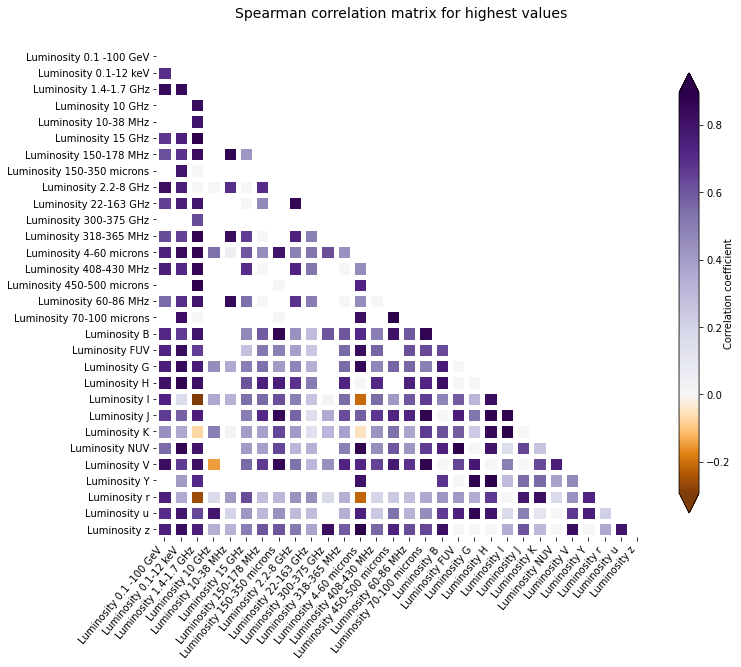

In [109]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr.loc[cols_high_corr, cols_high_corr], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr.loc[cols_high_corr, cols_high_corr].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr.tolist()),1)
ax1.set_xticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

To compare these results, we can calculate the correlation matrix using Pearson's  
coefficient.

In [110]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
min_elements   = 20

corr_alt       = merged_lums_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_alt_abs   = corr_alt.abs()

Names of the pairs of columns with the  
highest correlations (and their values).

In [111]:
cols_alt_corr  = (corr_alt_abs.where(np.triu(np.ones(corr_alt_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

In [112]:
arr_alt_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_alt = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [113]:
cols_alt_corr[cols_alt_corr<corr_thresh][:num_of_corr]

Luminosity K             Luminosity J                  0.893039
Luminosity J             Luminosity I                  0.884682
Luminosity H             Luminosity 70-100 microns     0.871486
Luminosity 10-38 MHz     Luminosity 60-86 MHz          0.871196
Luminosity 60-86 MHz     Luminosity 318-365 MHz        0.869238
Luminosity 1.4-1.7 GHz   Luminosity 2.2-8 GHz          0.869154
Luminosity 150-178 MHz   Luminosity 318-365 MHz        0.863477
Luminosity K             Luminosity I                  0.850591
Luminosity 15 GHz        Luminosity 2.2-8 GHz          0.846841
Luminosity u             Luminosity 10 GHz             0.842778
Luminosity 1.4-1.7 GHz   Luminosity 599-635 MHz        0.838395
Luminosity 60-86 MHz     Luminosity 408-430 MHz        0.828544
Luminosity 10-38 MHz     Luminosity 150-178 MHz        0.821207
Luminosity z             Luminosity 450-500 microns    0.815173
Luminosity 1.4-1.7 GHz   Luminosity 318-365 MHz        0.798970
Luminosity FUV           Luminosity 0.1 

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

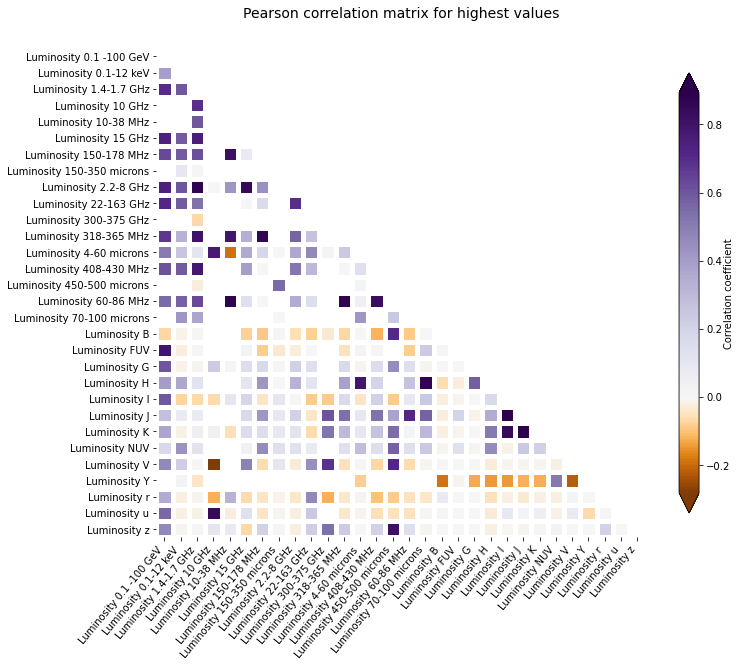

In [114]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr_alt.tolist()),1)
ax1.set_xticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Assess blank spaces

For future calculations, and given the large amount of blank spaces seen in  
the correlation matrix plot, we also want to understand the level of sparsity of our sample.  
We use the package `missingno` to represent how many values are missing  
in our catalog.

First, we calculate the level of *completeness* (how many sources have valid measurements) of each column for the whole dataset.

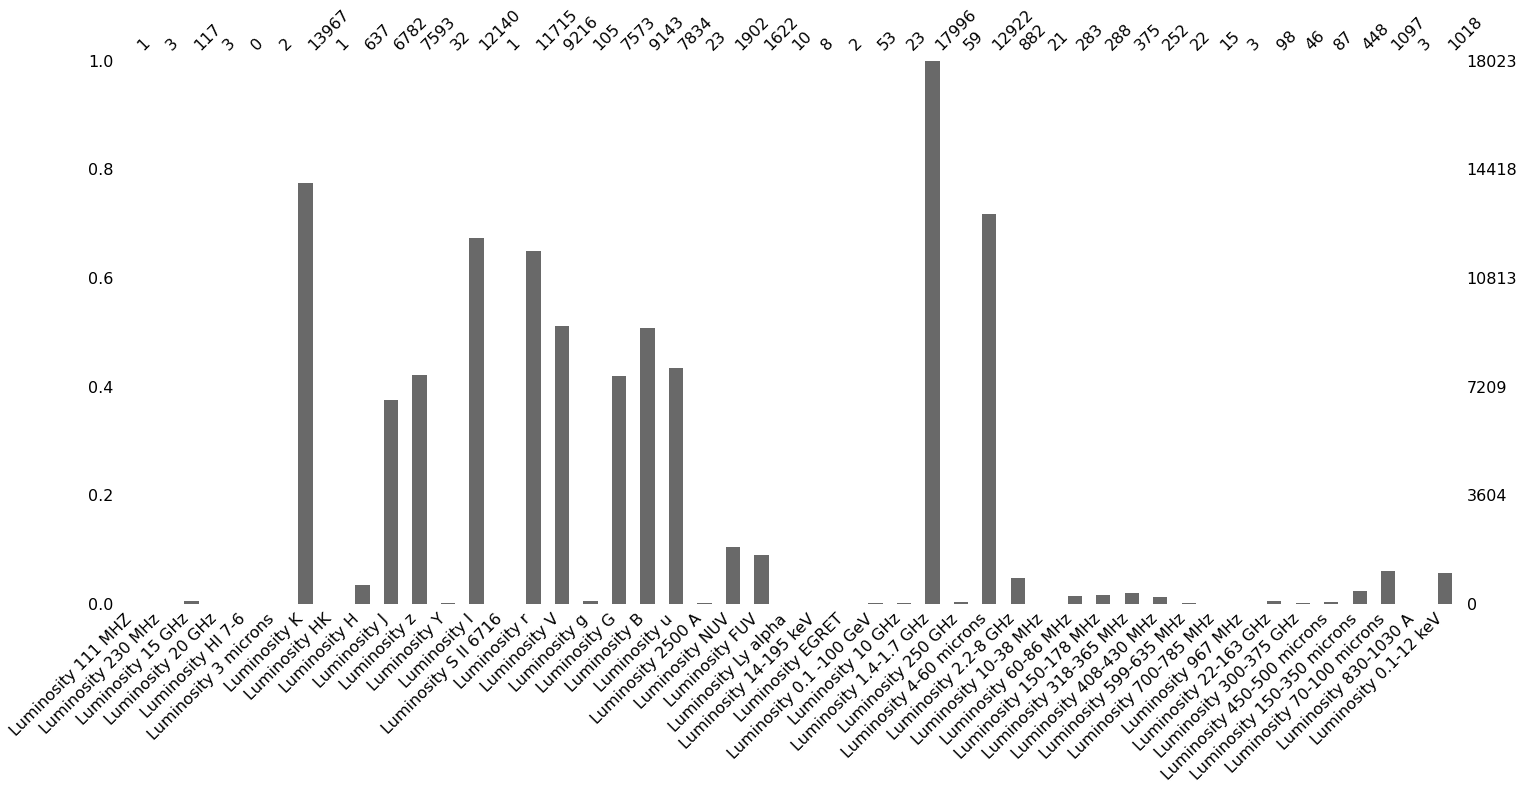

In [115]:
# msno.matrix(merged_lums_catalog_df)
msno.bar(merged_lums_catalog_df)

Now, we do it for only the most highly correlated columns.

In [116]:
used_data = pd.DataFrame(merged_lums_catalog_df[cols_high_corr])

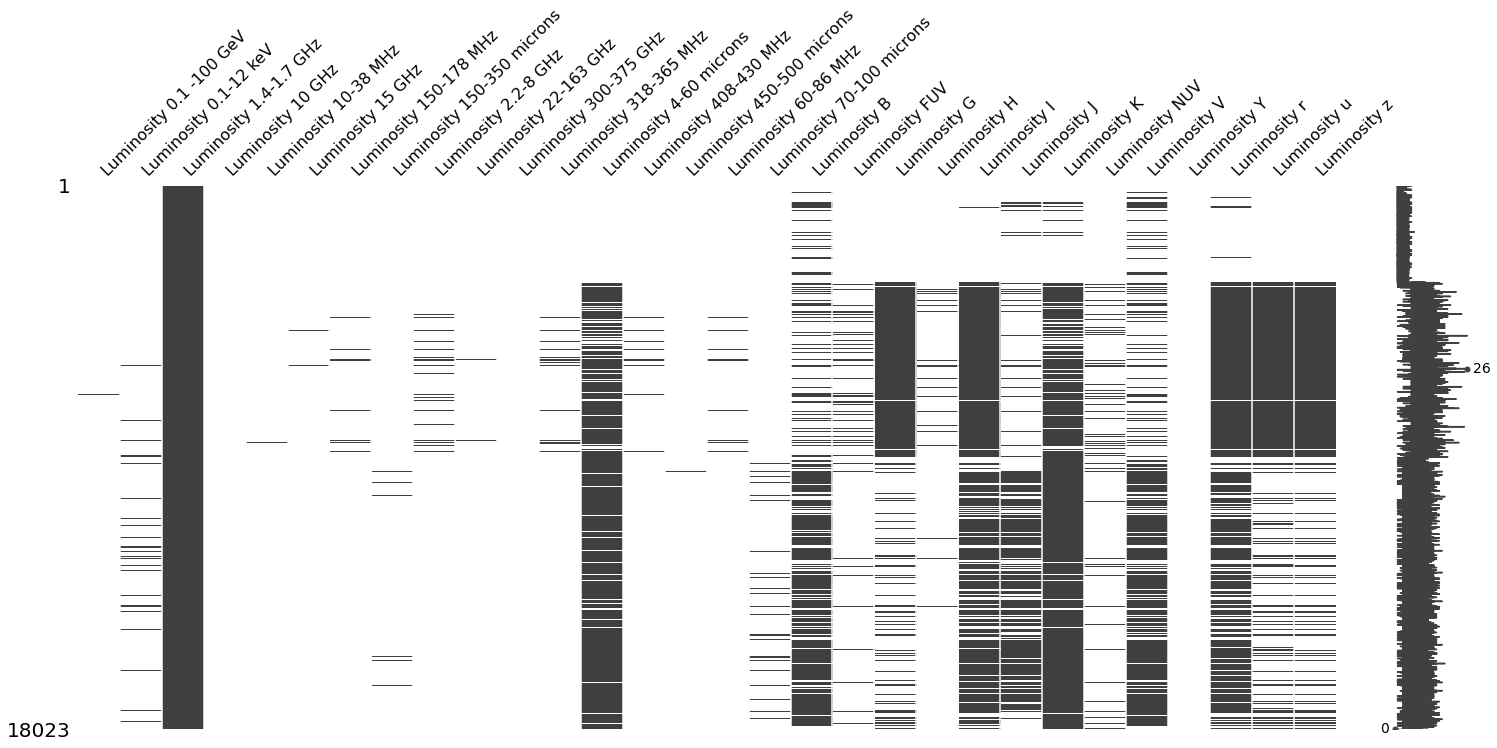

In [117]:
msno.matrix(used_data)

The right-most column in the chart shows the general shape of the data *completeness* of each selected row.  
It also points out the rows with the maximum and minimum nullity in the dataset.

This package allows us also to plot how correlated are the correlated behaviors  
of absence or presence of data for pairs of columns. A dendrogram can be plotted to  
understand any correlation in the lack of data.

In [118]:
# msno.dendrogram(merged_lums_catalog_df[cols_high_corr])

Numerically, we can also show the percentage of values in each column populated with NaN values.

For the columns with less invalid values, we have:

In [119]:
(merged_lums_catalog_df.isnull().sum()/len(merged_lums_catalog_df)*100).sort_values(ascending=True)[:25]

Luminosity 1.4-1.7 GHz         0.149809
Luminosity K                  22.504577
Luminosity 4-60 microns       28.302724
Luminosity I                  32.641625
Luminosity r                  34.999723
Luminosity V                  48.865339
Luminosity B                  49.270377
Luminosity u                  56.533319
Luminosity z                  57.870499
Luminosity G                  57.981468
Luminosity J                  62.370305
Luminosity NUV                89.446818
Luminosity FUV                91.000388
Luminosity 70-100 microns     93.913333
Luminosity 0.1-12 keV         94.351662
Luminosity 2.2-8 GHz          95.106253
Luminosity H                  96.465627
Luminosity 150-350 microns    97.514287
Luminosity 318-365 MHz        97.919325
Luminosity 150-178 MHz        98.402042
Luminosity 60-86 MHz          98.429784
Luminosity 408-430 MHz        98.601787
Luminosity 15 GHz             99.350829
Luminosity g                  99.417411
Luminosity 22-163 GHz         99.456250


And, for the features with the highest number of invalid entries:

In [120]:
(merged_lums_catalog_df.isnull().sum()/len(merged_lums_catalog_df)*100).sort_values(ascending=True)[-25:]

Luminosity 15 GHz              99.350829
Luminosity g                   99.417411
Luminosity 22-163 GHz          99.456250
Luminosity 450-500 microns     99.517283
Luminosity 250 GHz             99.672641
Luminosity 0.1 -100 GeV        99.705931
Luminosity 300-375 GHz         99.744771
Luminosity Y                   99.822449
Luminosity 2500 A              99.872385
Luminosity 10 GHz              99.872385
Luminosity 599-635 MHz         99.877934
Luminosity 10-38 MHz           99.883482
Luminosity 700-785 MHz         99.916773
Luminosity Ly alpha            99.944515
Luminosity 14-195 keV          99.955612
Luminosity 830-1030 A          99.983355
Luminosity 967 MHz             99.983355
Luminosity 20 GHz              99.983355
Luminosity 230 MHz             99.983355
Luminosity 3 microns           99.988903
Luminosity EGRET               99.988903
Luminosity S II 6716           99.994452
Luminosity HK                  99.994452
Luminosity 111 MHZ             99.994452
Luminosity HI 7-

---

# Impute empty values

Given the large proportion of empty (`NaN`) values in our dataset, we want to modify  
our table in order to make it easier to be analyzed by clustering algorithms or other type of ML codes.

Thus, we can replace non-numeric elements with some value. In this case, we choose zero ($0$) or $-99$ (as it is a very unlikely value in this context).

In [121]:
# backup_filled_lums_cat_df = filled_lums_cat_df.copy()
# filled_lums_cat_df = merged_lums_catalog_df.dropna(axis='columns', how='all')
# filled_lums_cat_df = filled_lums_cat_df.fillna(0)
# filled_lums_cat_df = filled_lums_cat_df.replace('inf', 0)

We can, also, replace the missing values with the mean of the selected column.

First, we discard columns containing less than one element.  
Some columns might have similar data (similar observational properties) and  
discarding before combining (in some way) them might have an impact in further calculations.

In [122]:
# filled_lums_cat_df = merged_lums_catalog_df.dropna(axis='columns', how='all')
filled_lums_cat_df = merged_lums_catalog_df.dropna(axis='columns', thresh=20)
col_names_non_drop = filled_lums_cat_df.columns

It is important to keep in mind that columns which have all their values as NaN  
might still have upper limits. These values have not been taken into account in this study.

Now, we replace the missing values.

In [123]:
# imputer       = SimpleImputer(missing_values=np.nan, strategy='median')
imputer       = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-99.00)
imputed_array = imputer.fit_transform(filled_lums_cat_df, filled_lums_cat_df)

Reassing the new (replaced) data into the old Table

In [124]:
filled_lums_cat_df = pd.DataFrame(imputed_array, columns=col_names_non_drop)

---

In [125]:
np.shape(merged_lums_catalog_df.columns)

(47,)

In [126]:
np.shape(filled_lums_cat_df.columns)

(34,)

---

# Recreate correlation matrix

Now, we can repeat parts of the previous procedures with our data.

The option `min_elements` tells the code to obtain the correlation matrix  
only for pairs of columns with more than this number of elements in common.

In [127]:
num_of_rows      = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols      = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements     = 20
# corr             = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled      = filled_lums_cat_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled  = corr_filled.abs()

Ordered list of highly correlated pairs of columns.

In [128]:
cols_corr_filled = (corr_abs_filled.where(np.triu(np.ones(corr_abs_filled.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [129]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [130]:
arr_cols_filled       = np.array([np.array(row) for row in cols_corr_filled.keys()[cols_corr_filled<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled = np.unique(np.concatenate((arr_cols_filled[:, 0], arr_cols_filled[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [131]:
cols_corr_filled[cols_corr_filled<corr_thresh][:num_of_corr]

Luminosity I                Luminosity r                  0.881258
Luminosity G                Luminosity u                  0.878404
Luminosity z                Luminosity u                  0.861123
Luminosity K                Luminosity J                  0.730026
Luminosity 60-86 MHz        Luminosity 318-365 MHz        0.711789
Luminosity K                Luminosity V                  0.701924
                            Luminosity B                  0.678472
Luminosity J                Luminosity I                  0.667676
Luminosity 150-178 MHz      Luminosity 318-365 MHz        0.657400
Luminosity J                Luminosity r                  0.647826
Luminosity 60-86 MHz        Luminosity 150-178 MHz        0.644010
Luminosity J                Luminosity V                  0.631788
Luminosity K                Luminosity I                  0.628316
Luminosity J                Luminosity B                  0.616694
Luminosity 2.2-8 GHz        Luminosity 318-365 MHz        0.59

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

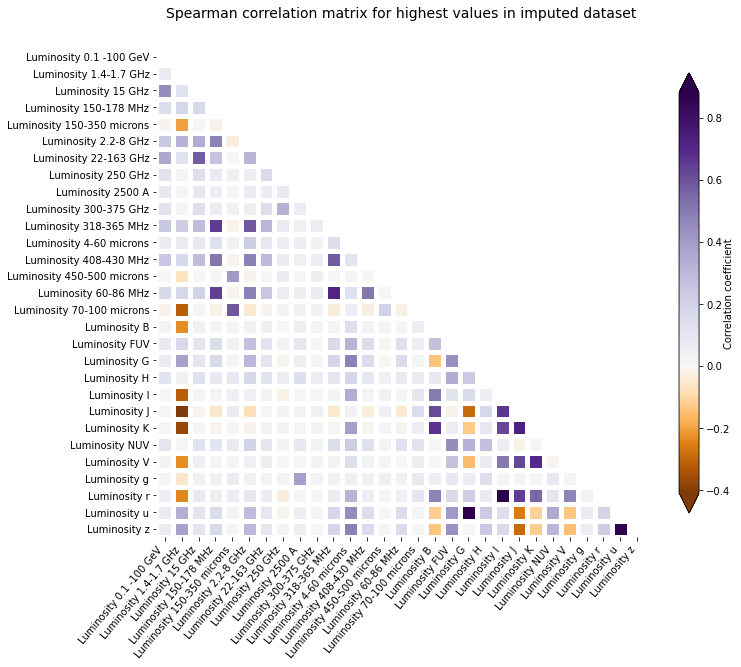

In [132]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled]
# arr_corr_filled[(arr_corr_filled > corr_thresh) & (arr_corr_filled < 1)] = 0
# arr_corr_filled[(arr_corr_filled < -corr_thresh) & (arr_corr_filled > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].mask(mask_corr)
arr_corr_filled[arr_corr_filled > corr_thresh] = 0
arr_corr_filled[arr_corr_filled < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled[arr_corr_filled > -1].values)
vmax      = np.nanmax(arr_corr_filled[arr_corr_filled < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(cols_high_corr_filled.tolist()),1)
ax1.set_xticks(np.arange(arr_corr_filled.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values in imputed dataset', size=14)

ax1.set_aspect('equal')

Another change we can make is related to the position of the columns in the correlation matrix.  
It is possible to change their order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [133]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [134]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [135]:
X                      = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].values
d                      = hc.distance.pdist(X)
L                      = hc.linkage(d, method='complete')
ind                    = hc.fcluster(L, 0.5*d.max(), 'distance')
ordered_columns_filled = [corr_filled[cols_high_corr_filled].columns.tolist()[i] for i in list((np.argsort(ind)))]
corr_filled_ordered    = corr_filled[cols_high_corr_filled].reindex(columns=ordered_columns_filled)
corr_filled_ordered    = corr_filled_ordered.reindex(index=ordered_columns_filled)

Now, we can replot the newly ordered correlation matrix.

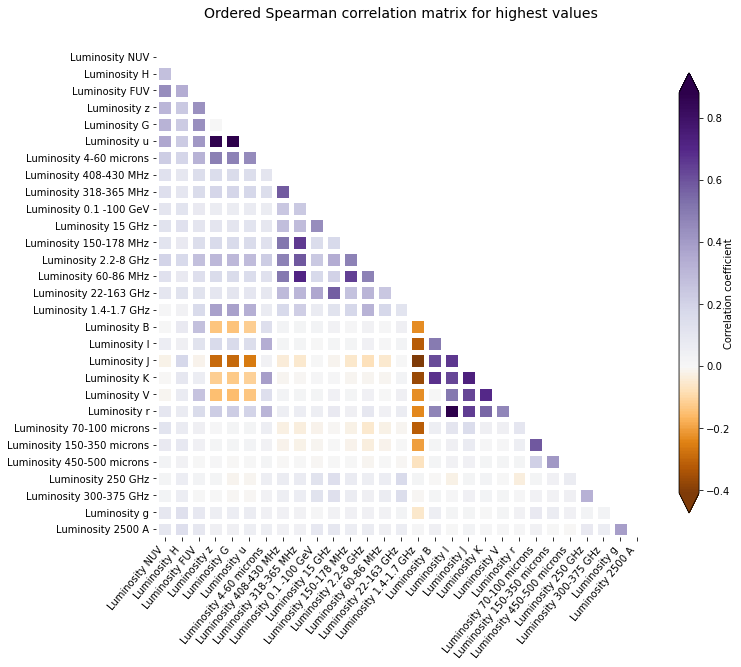

In [136]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled].mask(mask_corr)
arr_corr_filled_ordered[arr_corr_filled_ordered > corr_thresh] = 0
arr_corr_filled_ordered[arr_corr_filled_ordered < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered[arr_corr_filled_ordered > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered[arr_corr_filled_ordered < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Ordered Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Analyze feature relevance

Since the number of features our dataset has is high, we want to study their behavior  
in order to drop some of these features. Some algorithms have been developed to assess  
the importance of the information contained by each feature in the context of the overall  
behavior of the full sample.

A relevant measure of the quality of the variables (columns) we use has to do with  
their variance (or standard deviation). The differences between the variances among the columns  
should not be too high. When one column has too low variance, it does not add extra information  
to the overall table.

We can calculate the variances for all the columns.

In [137]:
order_variance        = filled_lums_cat_df.var().sort_values(ascending=False)
cols_ordered_variance = order_variance.index

Show the first $10$ elements.

In [138]:
order_variance[:10]

Luminosity FUV                2.654984e+72
Luminosity 2500 A             1.080591e+71
Luminosity g                  1.141440e+70
Luminosity 150-350 microns    5.338362e+68
Luminosity B                  5.294120e+67
Luminosity r                  5.162602e+67
Luminosity G                  3.830211e+67
Luminosity Y                  2.493133e+67
Luminosity u                  7.818944e+66
Luminosity z                  2.010162e+66
dtype: float64

Show the last $10$ elements.

In [139]:
order_variance[-10:]

Luminosity 599-635 MHz       4.168547e+53
Luminosity J                 1.011562e+53
Luminosity I                 7.412151e+52
Luminosity K                 5.197768e+52
Luminosity 4-60 microns      1.994525e+51
Luminosity 70-100 microns    1.534332e+51
Luminosity H                 1.351322e+49
Luminosity NUV               3.554069e+46
Luminosity 0.1-12 keV        1.294024e+41
Luminosity 0.1 -100 GeV      9.036724e+28
dtype: float64

These results can be seen graphically with the help of the Principal Component Analysis (`PCA`) algorithm.

In [140]:
pca = PCA()
pca.fit_transform(filled_lums_cat_df)
pca_variance = pca.explained_variance_

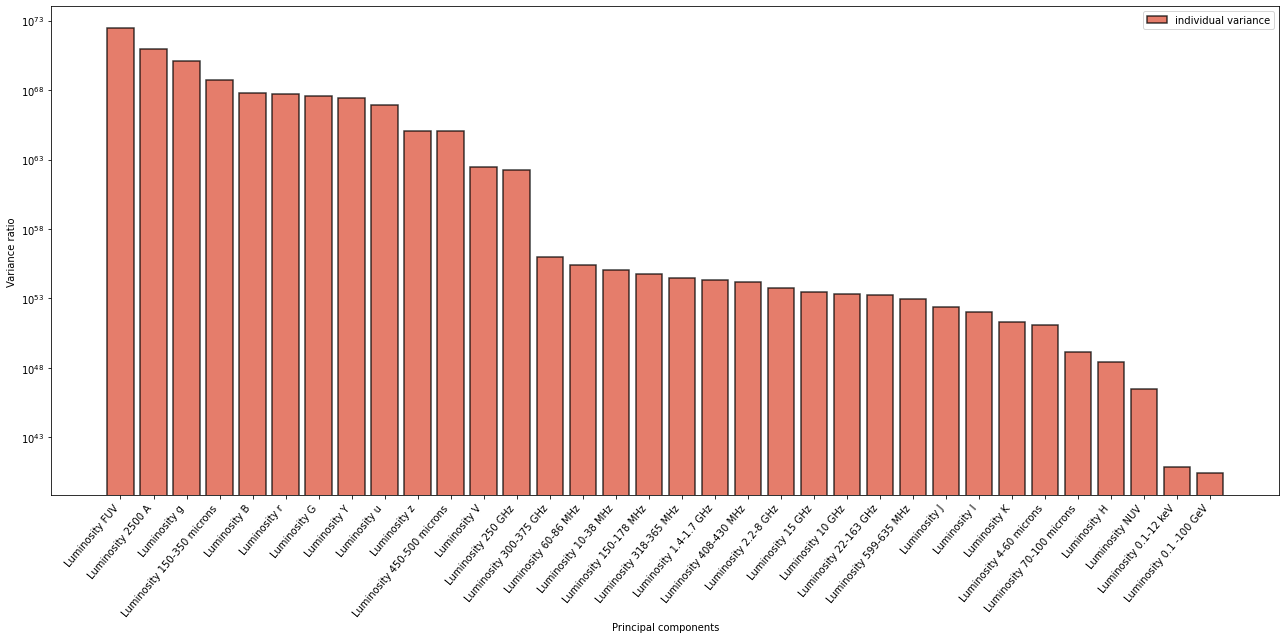

In [141]:
fig = plt.figure(figsize=(22,9))
ax1 = fig.add_subplot(111)

plt.bar(range(np.shape(cols_ordered_variance)[0]), pca_variance, alpha=0.75, align='center',\
        label='individual variance', color=colors[3], edgecolor='k', lw=1.5)
plt.legend()
ax1.set_ylabel('Variance ratio')
ax1.set_xlabel('Principal components')
ax1.set_yscale('log')
ticks = np.arange(0,len(cols_ordered_variance),1);
ax1.set_xticks(ticks);
ax1.set_xticklabels(cols_ordered_variance, rotation=50, horizontalalignment='right');

It can be seen that most of the variance of the dataset is explained by seven features.  
The rest of features show variance values orders of magnitude lower (including `Luminosity 1.4 GHz`).

---

# Remove highly correlated features

We can remove the features which do not add extra information to our dataset.  
This can be achieved taking the most highly correlated pairs of columns and  
discarding the feature with the lowest variance (i.e., the least relevant feature).

Another reason to explore these features is that they might have too similar values.  
This can be an expression of the imputation of missing values since many entries  
show the same value (if the imputation has been applied with a constant value for all columns).

In [142]:
high_corr_thresh            = 0.95

In [143]:
high_corr_pairs             = cols_corr_filled[cols_corr_filled > high_corr_thresh]  # Already discarded self correlations

In [144]:
filled_lums_clean_df        = filled_lums_cat_df.copy()

cols_high_corr_filled_clean = np.unique(high_corr_pairs.index.tolist()).tolist()

In [145]:
np.shape(cols_high_corr_filled_clean)

(2,)

In [146]:
for pair in high_corr_pairs.index.to_list():
    col_a, col_b = pair
    if col_a not in cols_high_corr_filled_clean or col_b not in cols_high_corr_filled_clean: continue
    var_a = order_variance[col_a]
    var_b = order_variance[col_b]
    if var_a < var_b:
        filled_lums_clean_df.drop(col_a, inplace=True, axis='columns')
        cols_high_corr_filled_clean.remove(col_a)
    else:
        filled_lums_clean_df.drop(col_b, inplace=True, axis='columns')
        cols_high_corr_filled_clean.remove(col_b)

In [147]:
filled_lums_clean_df.shape

(18023, 33)

In [148]:
np.shape(cols_high_corr_filled_clean)

(1,)

Thus, we have removed $13$ features from our dataset.  
Our sample now displays $88$ features.

---

# Repeat previous calculations

Now, we can obtain the correlation matrix and all its by-products  
as previously shown.

In [149]:
num_of_rows            = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols            = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements           = 20
# corr                   = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean      = filled_lums_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled_clean  = corr_filled_clean.abs()

Ordered list of highly correlated pairs of columns.

In [150]:
cols_corr_filled_clean = (corr_abs_filled_clean.where(np.triu(np.ones(corr_abs_filled_clean.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [151]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [152]:
arr_cols_filled_clean       = np.array([np.array(row) for row in cols_corr_filled_clean.keys()[cols_corr_filled_clean<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean = np.unique(np.concatenate((arr_cols_filled_clean[:, 0], arr_cols_filled_clean[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [153]:
cols_corr_filled_clean[cols_corr_filled_clean<corr_thresh][:num_of_corr]

Luminosity I                Luminosity r                  0.881258
Luminosity G                Luminosity u                  0.878404
Luminosity K                Luminosity J                  0.730026
Luminosity 60-86 MHz        Luminosity 318-365 MHz        0.711789
Luminosity K                Luminosity V                  0.701924
                            Luminosity B                  0.678472
Luminosity J                Luminosity I                  0.667676
Luminosity 150-178 MHz      Luminosity 318-365 MHz        0.657400
Luminosity J                Luminosity r                  0.647826
Luminosity 60-86 MHz        Luminosity 150-178 MHz        0.644010
Luminosity J                Luminosity V                  0.631788
Luminosity K                Luminosity I                  0.628316
Luminosity J                Luminosity B                  0.616694
Luminosity 2.2-8 GHz        Luminosity 318-365 MHz        0.590723
Luminosity 150-350 microns  Luminosity 70-100 microns     0.58

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

Change directlu the column order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [154]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [155]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [156]:
X_clean                      = corr_filled_clean.loc[cols_high_corr_filled_clean, cols_high_corr_filled_clean].values
d_clean                      = hc.distance.pdist(X_clean)
L_clean                      = hc.linkage(d_clean, method='complete')
ind_clean                    = hc.fcluster(L_clean, 0.5*d_clean.max(), 'distance')
ordered_columns_filled_clean = [corr_filled_clean[cols_high_corr_filled_clean].columns.tolist()[i] for i in list((np.argsort(ind_clean)))]
corr_filled_ordered_clean    = corr_filled_clean[cols_high_corr_filled_clean].reindex(columns=ordered_columns_filled_clean)
corr_filled_ordered_clean    = corr_filled_ordered_clean.reindex(index=ordered_columns_filled_clean)

Now, we can replot the newly ordered correlation matrix.

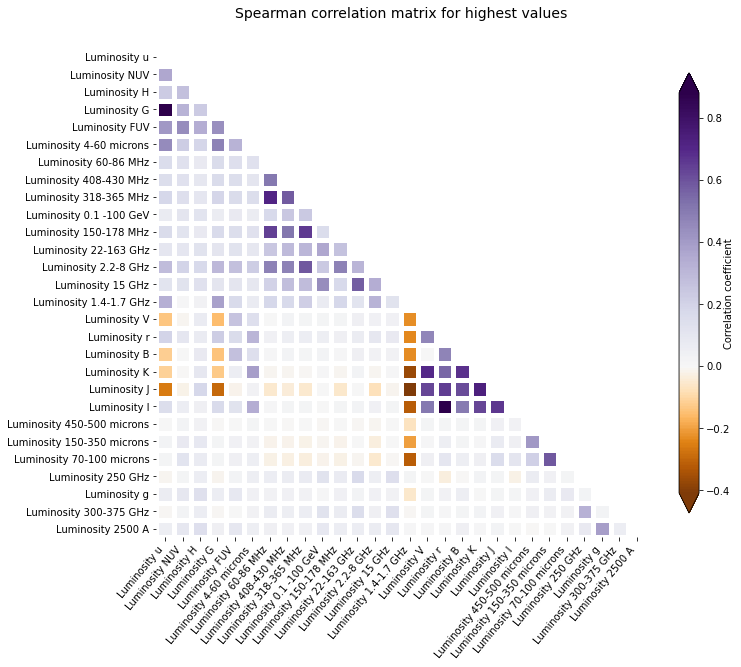

In [157]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean = corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean].mask(mask_corr)
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > corr_thresh] = 0
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

Comparing that to the use of Pearson correlation values.

In [158]:
num_of_rows                = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols                = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements               = 20
# corr                       = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean_alt      = filled_lums_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_abs_filled_clean_alt  = corr_filled_clean_alt.abs()

Ordered list of highly correlated pairs of columns.

In [159]:
cols_corr_filled_clean_alt = (corr_abs_filled_clean_alt.where(np.triu(np.ones(corr_abs_filled_clean_alt.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [160]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [161]:
arr_cols_filled_clean_alt       = np.array([np.array(row) for row in cols_corr_filled_clean_alt.keys()[cols_corr_filled_clean_alt<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean_alt = np.unique(np.concatenate((arr_cols_filled_clean_alt[:, 0], arr_cols_filled_clean_alt[:, 1])))  # Array with individual column names from highest correlations

In [162]:
X_clean_alt                      = corr_filled_clean_alt.loc[cols_high_corr_filled_clean_alt, cols_high_corr_filled_clean_alt].values
d_clean_alt                      = hc.distance.pdist(X_clean_alt)
L_clean_alt                      = hc.linkage(d_clean_alt, method='complete')
ind_clean_alt                    = hc.fcluster(L_clean_alt, 0.5*d_clean_alt.max(), 'distance')
ordered_columns_filled_clean_alt = [corr_filled_clean_alt[cols_high_corr_filled_clean_alt].columns.tolist()[i] for i in list((np.argsort(ind_clean_alt)))]
corr_filled_ordered_clean_alt    = corr_filled_clean_alt[cols_high_corr_filled_clean_alt].reindex(columns=ordered_columns_filled_clean_alt)
corr_filled_ordered_clean_alt    = corr_filled_ordered_clean_alt.reindex(index=ordered_columns_filled_clean_alt)

Now, we can replot the newly ordered correlation matrix.

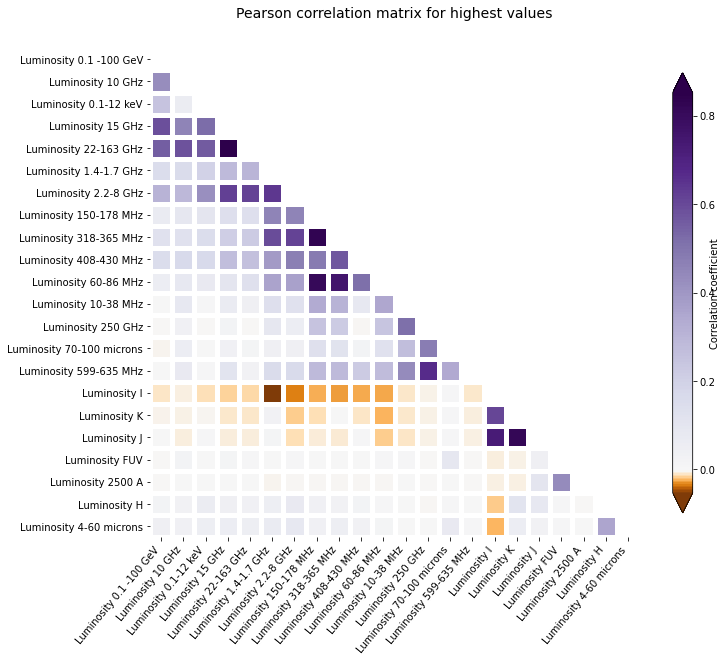

In [163]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt, ordered_columns_filled_clean_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean_alt = corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt, ordered_columns_filled_clean_alt].mask(mask_corr)
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > corr_thresh] = 0
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean_alt, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean_alt),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Clustering calculations

As a way to extend our analysis, we can construct, and plot, the dendrogram for our data.  
This tool can be useful to determine possible clustering among the columns.

We are going to use the table with imputed values and with highly correlated features removed.

In [164]:
# generate the linkage matrix
Z = hc.linkage(filled_lums_clean_df, 'ward')

We plot a reduced version of the dendrogram.

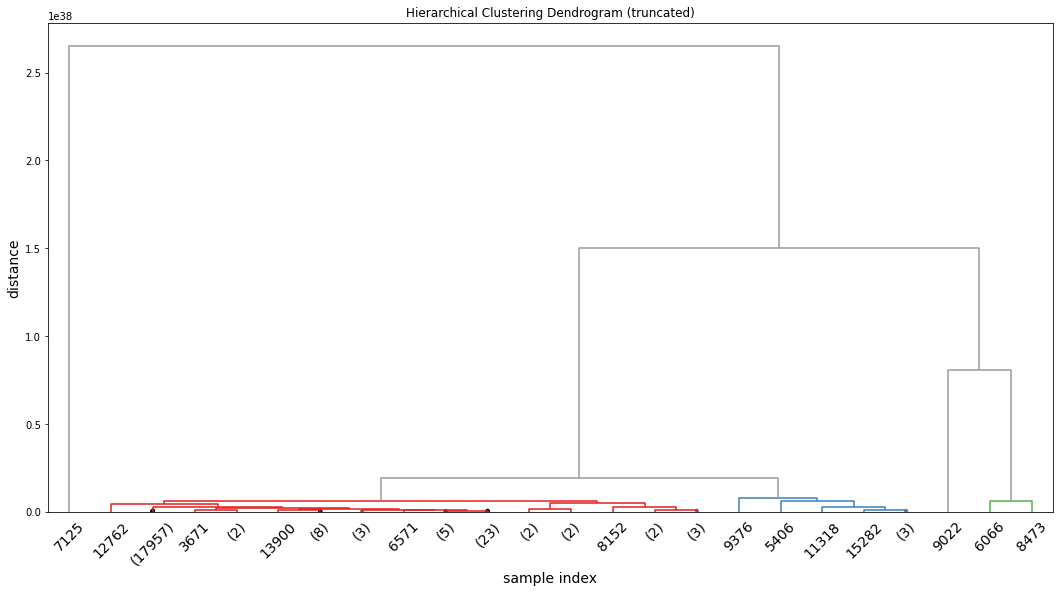

In [165]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(111)

# Custom color for branches
cmap_use   = cm.get_cmap('Set1')
cmap_array = cmap_use(np.linspace(0, 1, 10))
hc.set_link_color_palette([mcolors.rgb2hex(rgb[:3]) for rgb in cmap_array])

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index', size=14)
plt.ylabel('distance', size=14)
hc.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    # leaf_rotation=90.,
    color_threshold =1.5e37,
    above_threshold_color=cmap_use(1.0),  # color of first link
    leaf_font_size=14.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    orientation='top'
)

#plt.xscale('log')
plt.show()

# hc.set_link_color_palette(None)  # Reset color values

One conclusion that can be drawn from the previous dendrogram is related to  
the fact that the most part of our sample is shown as part of one major cluster  
and the remaining elements are depicted as, mostly, outliers.

Another option to find possible clusters within our data is using `t-SNE`  
(t-distributed Stochastic Neighbor Embedding, **van der Maaten and Hinton, 2008**) algorithms.  
A good guide for its use can be found in [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/).

In [166]:
X_tsne = TSNE(learning_rate=100, perplexity=35, n_iter=1500).fit_transform(filled_lums_clean_df)

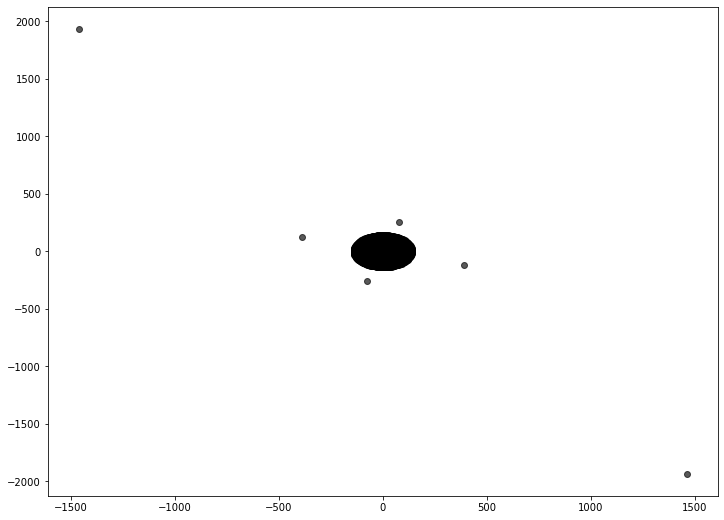

In [167]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c='k', alpha=0.65)

As with the results from the creation of the dendrogram, we can see that most of  
the elements of our sample gather into one major cluster and the remaining elements  
are depicted as outliers.

It is important to note that, in principle, distances between points do not hold any  
particular meaning. What is important is the overall distribution of elements.  
And

---

# Obtain elements of clusters

From the previous dendrogram and the `t-SNE` plot, we can see that we have two distinct populations for our sample.  
With this number ($2$), we can use Agglomerative Clustering from `sklearn` to obtain the labels  
for our sources.

In [168]:
# max_d         = 0.5e29
max_d         = 1.5e37

In [169]:
cluster_agg   = AgglomerativeClustering(n_clusters=None, distance_threshold=max_d, affinity='euclidean', linkage='ward')  
agg_cluster   = cluster_agg.fit_predict(filled_lums_clean_df)

In [170]:
array_values_agg = []
for cluster_idx in np.unique(agg_cluster):
    array_values_agg.append([cluster_idx, np.sum(agg_cluster == (cluster_idx))])
array_values_agg = np.array(array_values_agg)

In [171]:
ordered_array_values_agg = array_values_agg[array_values_agg[:,1].argsort()[::-1]]

In [172]:
for cluster_idx in ordered_array_values_agg[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 1	Elements: 18012
Cluster id: 0	Elements: 7
Cluster id: 2	Elements: 2
Cluster id: 4	Elements: 1
Cluster id: 3	Elements: 1


We can also fetch the values from the previous execution of the Dendrogram calculation.

In [173]:
clusters_dend = hc.fcluster(Z, max_d, criterion='distance')

In [174]:
array_values_dend = []
for cluster_idx in np.unique(clusters_dend):
    array_values_dend.append([cluster_idx, np.sum(clusters_dend == (cluster_idx))])
array_values_dend = np.array(array_values_dend)

In [175]:
ordered_array_values_dend = array_values_dend[array_values_dend[:,1].argsort()[::-1]]

In [176]:
for cluster_idx in ordered_array_values_dend[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 1	Elements: 18012
Cluster id: 2	Elements: 7
Cluster id: 3	Elements: 2
Cluster id: 5	Elements: 1
Cluster id: 4	Elements: 1


Thus, we can see that the results from both methods deliver the same results. There is one large cluster with more than $99 \%$ of the elements from the full sample. And the rest is shared among several minor clusters which could be classified as *outliers*.

---

# Save new database into a file

In order to repeat these calculation and add new features,  
we save our luminosity data into a file. We also add a new column  
with the redshift ($z$) values for our sources.

It is important to remember that we are not taking into account the  
uncertainties from the luminosities and the redshifts.

In [177]:
save_clean_lums_flag = False

In [178]:
if save_clean_lums_flag:
    filled_lums_clean_df['z_val'] = redshift

In [179]:
if save_clean_lums_flag:
    filled_lums_clean_df.to_hdf(cat_path + 'large_cat_lums_z_clean_2_5arcsec.h5', 'df')